In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import sys
import gc
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelBinarizer
import PIL
from PIL import Image
from IPython.display import SVG
from keras.utils import model_to_dot
import platform

import keras
from keras import layers
from keras import metrics
from keras.models import load_model
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras import optimizers
from keras import models
from keras.models import Sequential
from keras import preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications import VGG16
from keras.utils import plot_model

2023-08-25 13:29:40.958092: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-25 13:29:40.992341: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 13:29:41.556892: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Enable CUDA if OS is Windows

In [2]:
if platform.system() == 'Windows': 
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Set path and get all classes. ".DS_Store" needs to be removed on MacOS again

In [3]:
d = '/home/sebastian/Documents/Hauptprojekt/Daten_sorted/'
classes = (os.listdir(d))
if ".DS_Store" in classes:
    classes.remove(".DS_Store")
if "._.DS_Store" in classes:
    classes.remove("._.DS_Store")

In [4]:
print(classes)

['sales_order', 'purchase_order', 'utility_bill', 'debit_note', 'order', 'receipt', 'proforma', 'tax_invoice', 'credit_note']


Global variables

In [107]:
img_size = 224
batch_size = 32
epochs = 100
train_size = 0.7
val_size = 0.2
test_size = 0.1
seed = 4321
channels = 3
learning_rate = 0.00001

Get all Data

In [108]:
total_set = []
total_labels = []
counter_tax = 0 
counter_order = 0

for root, dirs, files in os.walk(d):
    for file in files:
        if file.endswith(".jpg"):
            label = root.split(os.path.sep)[-1]
            if label == "tax_invoice":
                counter_tax +=1
                if counter_tax % 10 == 0:
                    path = os.path.join(root, file)
                    total_set.append(path)
                    total_labels.append(label)
            elif label == "order":
                counter_order +=1
                if counter_order % 5 == 0:
                    path = os.path.join(root, file)
                    total_set.append(path)
                    total_labels.append(label)
            else:    
                path = os.path.join(root, file)
                total_set.append(path)
                total_labels.append(label)
            

# Return image class based on list entry (path)         
def getClass(img):
    return img.split(os.path.sep)[-2]


print(total_set[0])
print('GetClass : ', getClass(total_set[0]))
print('Label : ', total_labels[0])

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/sales_order/synthetic-6a8be7d3aa8c44d6af9a2656-052(1).jpg
GetClass :  sales_order
Label :  sales_order


In [109]:
len(total_set)

19395

In [110]:
img = mpimg.imread("/home/sebastian/Documents/Hauptprojekt/Daten_sorted/debit_note/2aeea3060ec34935b5a2a6e9(2).jpg")

Plot random samples

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/tax_invoice/synthetic-60342157e5654d1292205df4-813(1).jpg


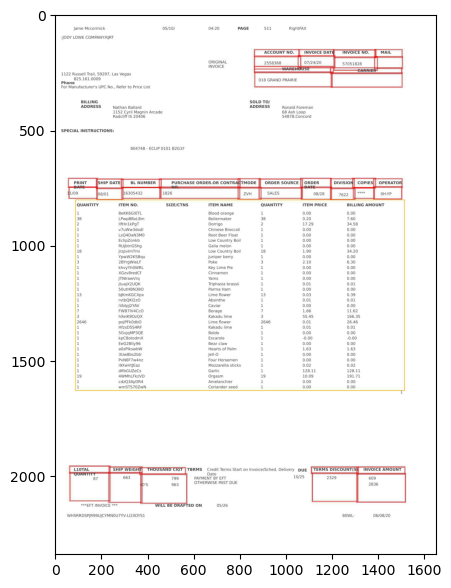

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/receipt/synthetic-410651d35003486c860e6985-120(1).jpg


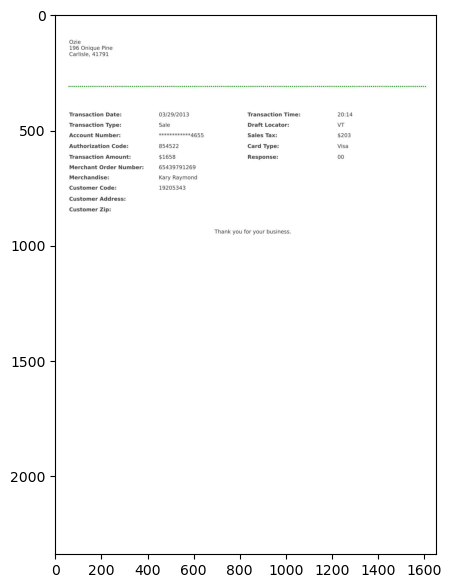

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/tax_invoice/synthetic-1c5cf2840ec745479b53bcad-958(1).jpg


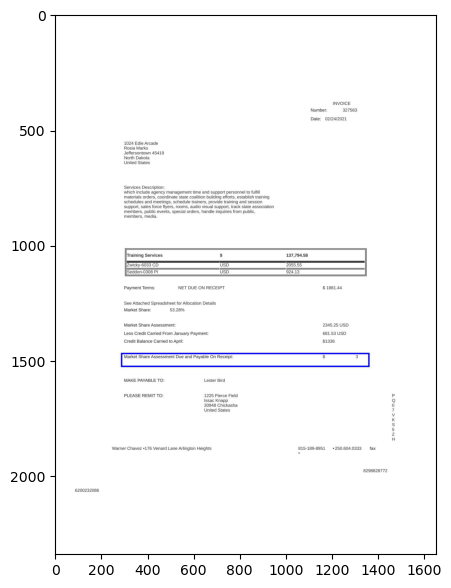

In [111]:
random.Random(seed).shuffle(total_set)

for ima in total_set[0:3] :
    print(ima)
    img = mpimg.imread(ima)
    plt.figure(figsize=(7,7))
    imgplot = plt.imshow(img, cmap="gray")
    plt.show()

Sorting the data in test, train and validation sets


In [112]:
# Get data and separate it in sets
total_len = len(total_set)
index = 0

train_set = []
train_label = []

val_set = []
val_label = []

test_set = []
test_label = []


for i in total_set[0: int(total_len*train_size)] :
    train_set.append(i)
    train_label.append(getClass(i))

    
index = int(total_len*train_size)+1
    
for i in total_set[index: int(index + total_len*val_size)] :
    val_set.append(i)
    val_label.append(getClass(i))
    
index = int(index + total_len*val_size)+1 

for i in total_set[index: total_len] :
    test_set.append(i)
    test_label.append(getClass(i))

print(train_set[750])
print(train_label[750])

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/tax_invoice/synthetic-f660a970247647439670abb7-533(1).jpg
tax_invoice


Visualizing class distribution for each set

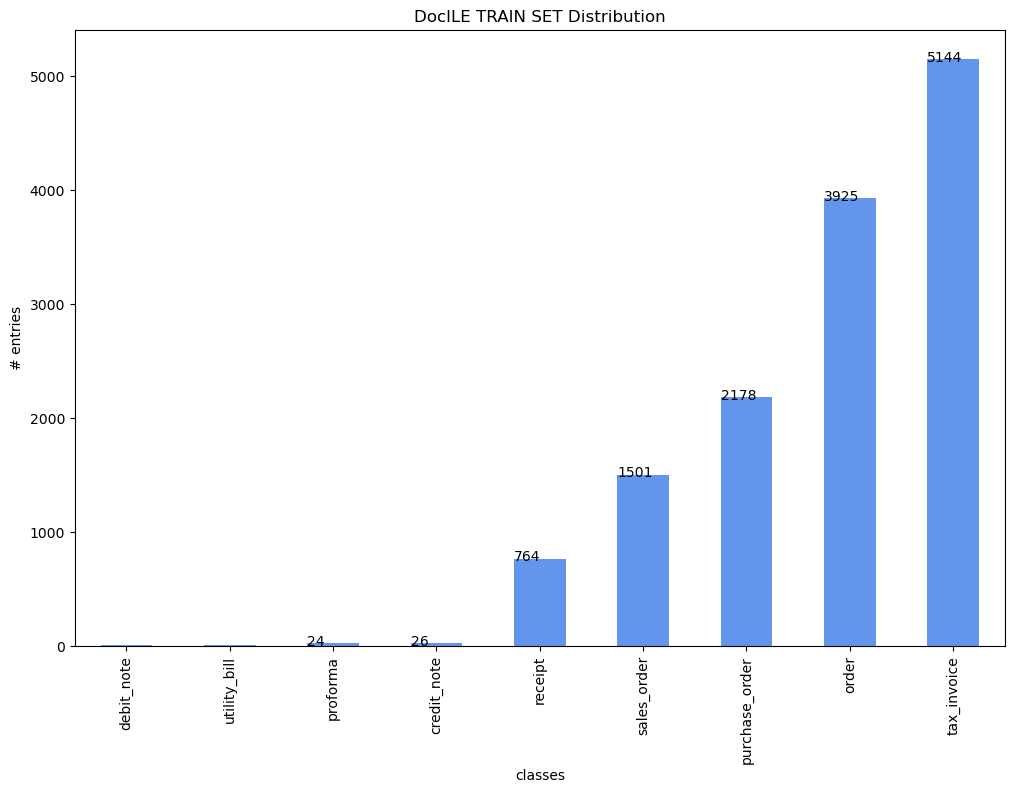

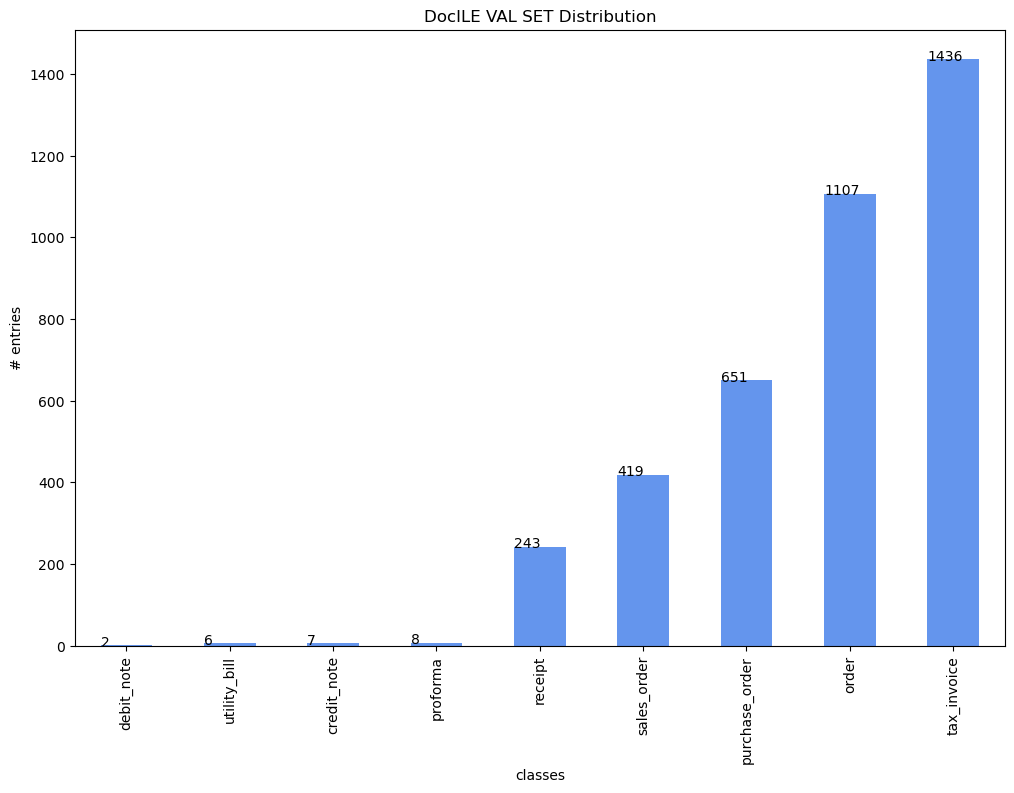

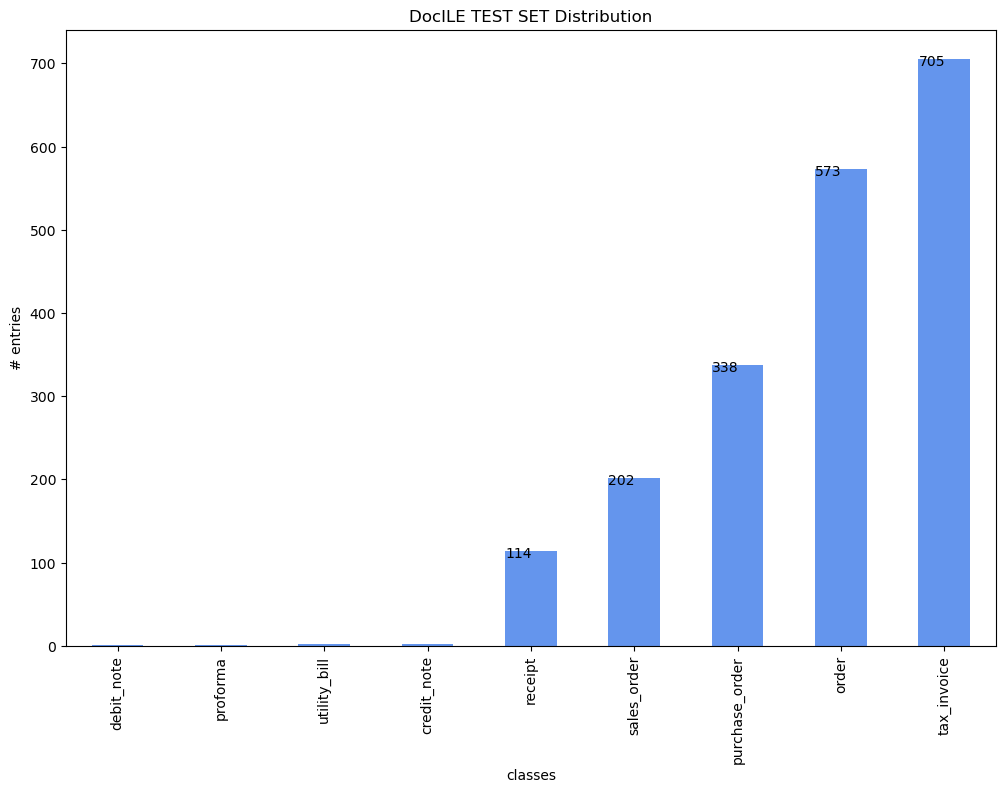

In [113]:
#################################################
# TRAIN SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in train_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('DocILE TRAIN SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-20))

#################################################
# VAL SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in val_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('DocILE VAL SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-3))
    
#################################################
# TEST SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in test_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('DocILE TEST SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-8))

Preprocess data (resize, transform to Numpy array and binarize)

In [ ]:
def process_images(img_set) : 
    processed_img = []
    counter = 0

    for i in range(len(img_set)):
        processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))
 
    return processed_img
    
data_train = process_images(train_set)

In [ ]:
def process_images(img_set) : 
    processed_img = []

    for i in range(len(img_set)):
            processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))    
    
    return processed_img
    
data_test = process_images(test_set)

In [ ]:
def process_images(img_set) : 
    processed_img = []

    for i in range(len(img_set)):
              processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))
        
    return processed_img
    
data_val = process_images(val_set)

In [ ]:
test_set[200]

In [ ]:
test_label[200]

In [ ]:
y_test[200]

In [ ]:
list(classes)

In [ ]:
lb = LabelBinarizer()
lb.fit(list(classes))

x_train = np.array(data_train)
y_train =lb.transform(np.array(train_label))

x_test = np.array(data_test)
y_test = lb.transform(np.array(test_label))

x_val = np.array(data_val)
y_val = lb.transform(np.array(val_label))

print("train images shape : ", x_train.shape)
print("train labels shape : ", y_train.shape)
print(x_train[0])

print("test shape : ", x_test.shape)
print(y_test.shape)
print("valdiation shape : ", x_val.shape)
print(y_val.shape)


for i in range(3) :
    plt.figure(figsize=(6,6))
    imgplot = plt.imshow(x_train[i])


print(train_label[0])
print(y_train[0])
print(lb.classes_)

In [ ]:
len(x_train)

Save the sets to .npy file for use after restarting runtime

In [ ]:
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_train.npy', x_train)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_test.npy', x_test)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_train.npy', y_train)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_test.npy', y_test)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_val.npy', x_val)
np.save('//home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_val.npy', y_val)

load sets after restarting runtime

In [18]:
x_train = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_train.npy')
x_test = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_test.npy')
y_train = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_train.npy')
y_test = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_test.npy')
x_val = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_val.npy')
y_val = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_val.npy')

### Load Model

With "layer.trainable = False" you can freeze the layers of the base model. That means when your training the model that you only train the layers added to the base model. Training the whole model takes about three to four times longer for training since there are way more parameters to train.

For this project two models were testet. One with "layer.trainable = False" and one without it. 

In [19]:
base_model = VGG16(weights = "imagenet", include_top=False, input_shape = (img_size, img_size, channels))

for layer in base_model.layers:
    layer.trainable = False
    
base_model.summary()

2023-08-25 13:44:03.043655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22010 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Create custom model

Base is VGG16, adding a flatten layer, a Dense layer and a dropout layer. Last Dense layer specify the number of classes

In [20]:
model = models.Sequential()

model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu',  name='dense'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classes), activation='softmax',  name='predictions'))

model.summary()

print('Number of trainable weights : ', len(model.trainable_weights))

plot_model(model, to_file='model_VGG-16.png')
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 predictions (Dense)         (None, 9)                 1161      
                                                                 
Total params: 17927241 (68.39 MB)
Trainable params: 3212553 (12.25 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Number of

In [21]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Training the model with DocILE Data. Only the last added layers are trained

Compile : Configures the model for training.

Fit : Trains the model for a given number of epochs

https://keras.io/models/model/

In [22]:
model.compile(optimizer=optimizers.legacy.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy', f1_m,precision_m, recall_m])

train_model = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y_val))

Epoch 1/100


2023-08-25 13:45:05.146491: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-25 13:45:05.241063: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-08-25 13:45:05.242436: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-08-25 13:45:05.242472: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-08-25 13:45:05.242590: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


  5/425 [..............................] - ETA: 16s - loss: 22.2224 - accuracy: 0.0750 - f1_m: 0.0756 - precision_m: 0.0762 - recall_m: 0.0750

2023-08-25 13:45:05.661955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


425/425 [==============================] - 23s 52ms/step - loss: 4.3810 - accuracy: 0.5536 - f1_m: 0.5529 - precision_m: 0.5609 - recall_m: 0.5454 - val_loss: 0.5064 - val_accuracy: 0.8845 - val_f1_m: 0.8832 - val_precision_m: 0.8871 - val_recall_m: 0.8796
Epoch 2/100
425/425 [==============================] - 21s 50ms/step - loss: 0.8780 - accuracy: 0.7895 - f1_m: 0.7896 - precision_m: 0.8043 - recall_m: 0.7759 - val_loss: 0.2924 - val_accuracy: 0.9314 - val_f1_m: 0.9309 - val_precision_m: 0.9345 - val_recall_m: 0.9275
Epoch 3/100
425/425 [==============================] - 21s 50ms/step - loss: 0.5231 - accuracy: 0.8577 - f1_m: 0.8593 - precision_m: 0.8749 - recall_m: 0.8447 - val_loss: 0.2138 - val_accuracy: 0.9495 - val_f1_m: 0.9490 - val_precision_m: 0.9528 - val_recall_m: 0.9454
Epoch 4/100
425/425 [==============================] - 21s 50ms/step - loss: 0.3810 - accuracy: 0.8897 - f1_m: 0.8907 - precision_m: 0.9030 - recall_m: 0.8792 - val_loss: 0.1613 - val_accuracy: 0.9644 - va

425/425 [==============================] - 21s 50ms/step - loss: 0.0170 - accuracy: 0.9934 - f1_m: 0.9936 - precision_m: 0.9943 - recall_m: 0.9929 - val_loss: 0.0866 - val_accuracy: 0.9876 - val_f1_m: 0.9877 - val_precision_m: 0.9877 - val_recall_m: 0.9877
Epoch 32/100
425/425 [==============================] - 21s 50ms/step - loss: 0.0153 - accuracy: 0.9943 - f1_m: 0.9944 - precision_m: 0.9957 - recall_m: 0.9932 - val_loss: 0.0836 - val_accuracy: 0.9889 - val_f1_m: 0.9890 - val_precision_m: 0.9890 - val_recall_m: 0.9890
Epoch 33/100
425/425 [==============================] - 21s 50ms/step - loss: 0.0148 - accuracy: 0.9948 - f1_m: 0.9952 - precision_m: 0.9959 - recall_m: 0.9945 - val_loss: 0.0787 - val_accuracy: 0.9897 - val_f1_m: 0.9899 - val_precision_m: 0.9900 - val_recall_m: 0.9898
Epoch 34/100
425/425 [==============================] - 21s 50ms/step - loss: 0.0134 - accuracy: 0.9953 - f1_m: 0.9954 - precision_m: 0.9964 - recall_m: 0.9944 - val_loss: 0.0849 - val_accuracy: 0.9892 -

425/425 [==============================] - 21s 50ms/step - loss: 0.0052 - accuracy: 0.9984 - f1_m: 0.9983 - precision_m: 0.9985 - recall_m: 0.9982 - val_loss: 0.0941 - val_accuracy: 0.9907 - val_f1_m: 0.9908 - val_precision_m: 0.9908 - val_recall_m: 0.9908
Epoch 62/100
425/425 [==============================] - 21s 50ms/step - loss: 0.0056 - accuracy: 0.9979 - f1_m: 0.9979 - precision_m: 0.9980 - recall_m: 0.9977 - val_loss: 0.1118 - val_accuracy: 0.9897 - val_f1_m: 0.9898 - val_precision_m: 0.9898 - val_recall_m: 0.9898
Epoch 63/100
425/425 [==============================] - 21s 50ms/step - loss: 0.0059 - accuracy: 0.9982 - f1_m: 0.9983 - precision_m: 0.9986 - recall_m: 0.9980 - val_loss: 0.0985 - val_accuracy: 0.9907 - val_f1_m: 0.9908 - val_precision_m: 0.9908 - val_recall_m: 0.9908
Epoch 64/100
425/425 [==============================] - 21s 50ms/step - loss: 0.0045 - accuracy: 0.9985 - f1_m: 0.9982 - precision_m: 0.9985 - recall_m: 0.9980 - val_loss: 0.0960 - val_accuracy: 0.9902 -

425/425 [==============================] - 21s 50ms/step - loss: 0.0031 - accuracy: 0.9987 - f1_m: 0.9988 - precision_m: 0.9990 - recall_m: 0.9987 - val_loss: 0.1094 - val_accuracy: 0.9915 - val_f1_m: 0.9915 - val_precision_m: 0.9915 - val_recall_m: 0.9915
Epoch 92/100
425/425 [==============================] - 21s 50ms/step - loss: 0.0023 - accuracy: 0.9993 - f1_m: 0.9994 - precision_m: 0.9995 - recall_m: 0.9993 - val_loss: 0.1132 - val_accuracy: 0.9912 - val_f1_m: 0.9912 - val_precision_m: 0.9913 - val_recall_m: 0.9910
Epoch 93/100
425/425 [==============================] - 21s 50ms/step - loss: 0.0027 - accuracy: 0.9991 - f1_m: 0.9992 - precision_m: 0.9993 - recall_m: 0.9991 - val_loss: 0.1101 - val_accuracy: 0.9907 - val_f1_m: 0.9908 - val_precision_m: 0.9908 - val_recall_m: 0.9908
Epoch 94/100
425/425 [==============================] - 21s 50ms/step - loss: 0.0026 - accuracy: 0.9990 - f1_m: 0.9990 - precision_m: 0.9991 - recall_m: 0.9989 - val_loss: 0.1138 - val_accuracy: 0.9907 -

In [25]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=0)

Plot accuracy and loss of trained model

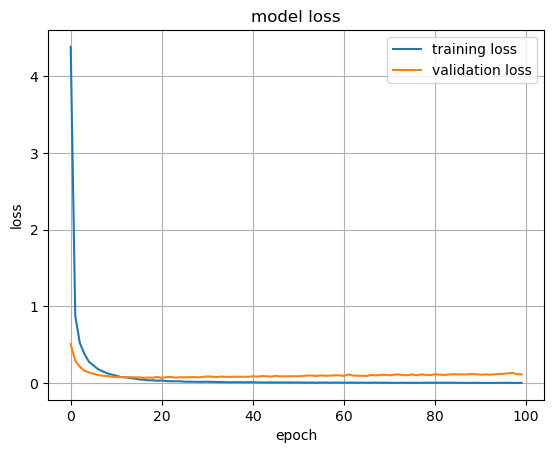

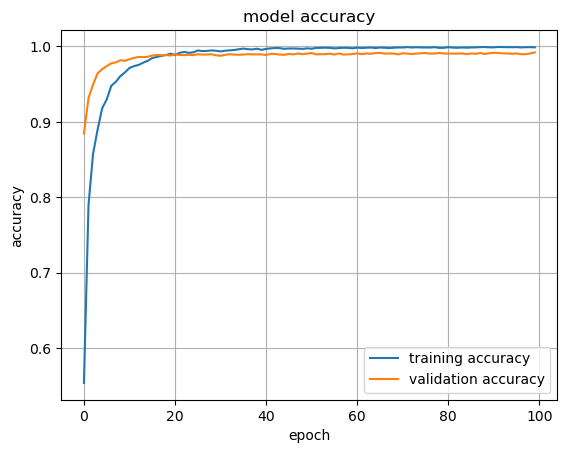

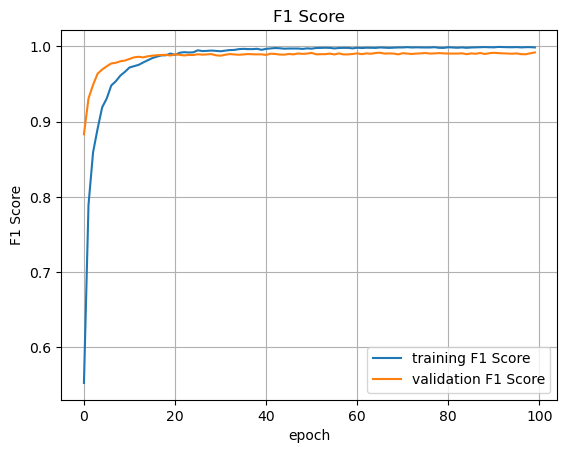

<Figure size 640x480 with 0 Axes>

In [23]:
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/VGG16/model_loss_added_layer_100epochs_10_5.png')

plt.plot(train_model.history['accuracy'])
plt.plot(train_model.history['val_accuracy'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
plt.show()
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/VGG16/model_acc_added_layer_100epochs_10_5.png')

plt.plot(train_model.history['f1_m'])
plt.plot(train_model.history['val_f1_m'])
plt.title('F1 Score')
plt.grid()
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend(['training F1 Score', 'validation F1 Score'], loc='lower right')
plt.show()
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/VGG16/F1_added_layer_100epochs_10_5.png')

Test prediction accuracy on test set

In [24]:
# combine predictions + average for better score ? 

score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

61/61 [==============================] - 3s 42ms/step - loss: 0.1129 - accuracy: 0.9886 - f1_m: 0.9887 - precision_m: 0.9887 - recall_m: 0.9887
Test loss: 0.11285386234521866
Test accuracy: 0.9886481165885925


Save Model with trained last layers

In [25]:
model.save('/home/sebastian/Documents/Hauptprojekt/Models/VGG16/trained_model_added_layer_10_5_100epochs.h5')

/home/sebastian/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Use Model on test set

In [104]:
#predictions = model.predict_classes(x_test, verbose=1)
#predictions_list = predictions.tolist()
#predicted_classes = lb.classes_
false_pred = []
true_pred = []

predictions=model.predict(x_test) 
predictions_list = predictions.tolist()
predicted_classes=np.argmax(predictions,axis=1)



count_true = 0
count_false = 0

for i, prediction in enumerate(predictions_list):
    print(i)
    state = True
    print(prediction)#
    print("hallo:" ,predicted_classes[i])
    if (lb.classes_[predicted_classes[i]] != test_label[i]) :
        state = False
        count_false += 1
        false_pred.append(test_label[i])
    else :
        true_pred.append(test_label[i])
        count_true += 1
    print("Prediction : ", classes[predicted_classes[i]], "   |   Real class : ", test_label[i],  "   |   Result : ", state)

print("\nNumber of success : ", count_true) 
print("Number of error : ", count_false) 
print("Error rate : ", count_true/len(test_label))

61/61 [==============================] - 2s 35ms/step
0
[2.645912657837454e-35, 5.120209942599852e-27, 1.9892160186300566e-22, 2.5140036010351397e-27, 3.9480089319824664e-29, 4.625803018367164e-31, 1.9745978859331102e-26, 1.0, 1.3056566649991218e-27]
hallo: 7
Prediction :  tax_invoice    |   Real class :  tax_invoice    |   Result :  True
1
[2.491288010508428e-15, 5.358720522707584e-17, 1.0, 3.0074980524106947e-15, 8.097791507439764e-14, 1.2818721338038724e-15, 1.9754969587474762e-16, 3.421823935312318e-10, 1.3072488438569172e-16]
hallo: 2
Prediction :  utility_bill    |   Real class :  order    |   Result :  True
2
[0.0, 0.0, 1.0, 0.0, 1.9561948597069477e-38, 0.0, 0.0, 1.4341870896228632e-25, 0.0]
hallo: 2
Prediction :  utility_bill    |   Real class :  order    |   Result :  True
3
[1.2152097947998474e-28, 1.3087926567275675e-28, 2.2295290726629687e-26, 7.025888733621856e-27, 6.908273564895529e-31, 5.675541110094362e-34, 4.3032200601690865e-27, 1.0, 2.3032445805447746e-25]
hallo: 7
P

Prediction :  proforma    |   Real class :  sales_order    |   Result :  True
521
[7.440505134697099e-23, 4.6551329359430444e-17, 1.2176361196994216e-14, 4.668982193464351e-19, 4.2086841824107157e-13, 5.590569135315416e-22, 1.0114476009700764e-16, 1.0, 4.438822806936651e-18]
hallo: 7
Prediction :  tax_invoice    |   Real class :  tax_invoice    |   Result :  True
522
[3.7327143671183133e-36, 4.62255172497453e-26, 1.2266591401704384e-26, 3.1759258858426055e-27, 1.2319901219774784e-20, 2.0486463485837017e-28, 3.856605380157442e-25, 1.0, 1.27419958454897e-28]
hallo: 7
Prediction :  tax_invoice    |   Real class :  tax_invoice    |   Result :  True
523
[1.3647080604770222e-21, 5.843918178546199e-27, 1.0, 5.709706995521382e-24, 1.011637951158714e-21, 6.718403184644496e-29, 2.8809504301183957e-16, 3.741166651103321e-14, 2.9604637108398285e-23]
hallo: 2
Prediction :  utility_bill    |   Real class :  order    |   Result :  True
524
[6.467923506924953e-31, 1.2092147076836643e-24, 3.28717373351

Print wrong classifications per class

In [105]:
print(f'"debit_note" was classified wrong {false_pred.count("debit_note")} time(s) out of {false_pred.count("debit_note") + true_pred.count("debit_note")} time(s)')
print(f'"proforma" was classified wrong {false_pred.count("proforma")} time(s) out of {false_pred.count("proforma") + true_pred.count("proforma")} time(s)')
print(f'"utility_bill" was classified wrong {false_pred.count("utility_bill")} time(s) out of {false_pred.count("utility_bill") + true_pred.count("utility_bill")} time(s)')
print(f'"credit_note" was classified wrong {false_pred.count("credit_note")} time(s) out of {false_pred.count("credit_note") + true_pred.count("credit_note")} time(s)')
print(f'"receipt" was classified wrong {false_pred.count("receipt")} time(s) out of {false_pred.count("receipt") + false_pred.count("receipt")} time(s)')
print(f'"sales_order" was classified wrong {false_pred.count("sales_order")} time(s) out of {false_pred.count("sales_order") + true_pred.count("sales_order")} time(s)')
print(f'"purchase_order" was classified wrong {false_pred.count("purchase_order")} time(s) out of {false_pred.count("purchase_order") + true_pred.count("purchase_order")} time(s)')
print(f'"order" was classified wrong {false_pred.count("order")} time(s) out of {false_pred.count("order") + true_pred.count("order")} time(s)')
print(f'"tax_invoice" was classified wrong {false_pred.count("tax_invoice")} time(s) out of {false_pred.count("tax_invoice") + true_pred.count("tax_invoice")} time(s)')

"debit_note" was classified wrong 1 time(s) out of 1 time(s)
"proforma" was classified wrong 1 time(s) out of 1 time(s)
"utility_bill" was classified wrong 1 time(s) out of 2 time(s)
"credit_note" was classified wrong 1 time(s) out of 2 time(s)
"receipt" was classified wrong 6 time(s) out of 12 time(s)
"sales_order" was classified wrong 1 time(s) out of 202 time(s)
"purchase_order" was classified wrong 1 time(s) out of 338 time(s)
"order" was classified wrong 6 time(s) out of 573 time(s)
"tax_invoice" was classified wrong 4 time(s) out of 705 time(s)
